# Fit atmosphere parameters using wavelet decomposition as input

- author Sylvie Dagoret-Campagne
- creation date : August 19th 2020

In [611]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [612]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [613]:
sys.path.append("../../tools/atmanalyticsim") # go to parent dir

In [614]:
import libatmscattering as atm

# Input files : wavelet decomposition coefficients

In [615]:
all_files=["lsst_atm_10year_wavelets_dataset1.fits",
           "lsst_atm_10year_wavelets_dataset2.fits",
           "lsst_atm_10year_wavelets_dataset3.fits",
           "lsst_atm_10year_wavelets_dataset4.fits",
           "lsst_atm_10year_wavelets_dataset5.fits",
           "lsst_atm_10year_wavelets_dataset6.fits",
           "lsst_atm_10year_wavelets_dataset7.fits",
           "lsst_atm_10year_wavelets_dataset8.fits",
           "lsst_atm_10year_wavelets_dataset9.fits"]

### Level of decomposition

- ilevel : from 1 to 9

In [616]:
ilevel = 2

In [617]:
ilevel_label="wavelet decomp level {}".format(ilevel)

In [618]:
input_file=all_files[ilevel]

In [619]:
hdu = fits.open(input_file)

In [620]:
hdr=hdu[0].header
data=hdu[0].data

In [621]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   20                                                  
NAXIS2  =                 3650                                                  
NBATMSIM=                 3650                                                  
ID_NUM  =                    0                                                  
ID_YEAR =                    1                                                  
ID_AM   =                    2                                                  
ID_VAOD =                    3                                                  
ID_PWV  =                    4                                                  
ID_O3   =                    5                                                  
ID_CLD  =                   

In [622]:
#NbAtmSimul=hdr['NBATMSIM']
idx_out_num=hdr['ID_NUM']
idx_out_year=hdr['ID_YEAR']
idx_out_am=hdr['ID_AM']
idx_out_vaod=hdr['ID_VAOD']
idx_out_pwv=hdr['ID_PWV']
idx_out_o3=hdr['ID_O3']
idx_out_cld=hdr['ID_CLD']
idx_out_res=hdr['ID_RES']

In [623]:
num=data[0:,idx_out_num]
year=data[0:,idx_out_year]
airmass=data[0:,idx_out_year]
vaod=data[0:,idx_out_vaod] # vertical aerosol depth
pwv=data[0:,idx_out_pwv]   # precipitable water vapor (mm)
o3=data[0:,idx_out_o3]     # ozone
cld=data[0:,idx_out_cld]   # clouds (not used)

In [624]:
coeff=data[:,idx_out_res:]

In [625]:
coeff

array([[ 2.00324219,  1.52381444, -0.09222375, ...,  0.24631883,
        -1.65551047, -0.00520482],
       [ 1.53320036,  1.46361626, -0.19350372, ...,  0.23165237,
        -1.73079587, -0.01709568],
       [ 2.11070673,  1.91002227, -0.18253978, ...,  0.20016853,
        -2.16991793, -0.01065391],
       ...,
       [ 2.16239243,  0.86796922,  0.19323001, ...,  0.32793005,
        -0.71318396,  0.00794895],
       [ 2.20309423,  1.15453053,  0.14201087, ...,  0.29740147,
        -1.10438126,  0.00551588],
       [ 1.88785076,  1.1490328 ,  0.04532459, ...,  0.28472018,
        -1.19548717, -0.00266076]])

In [626]:
N=coeff.shape[1]
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

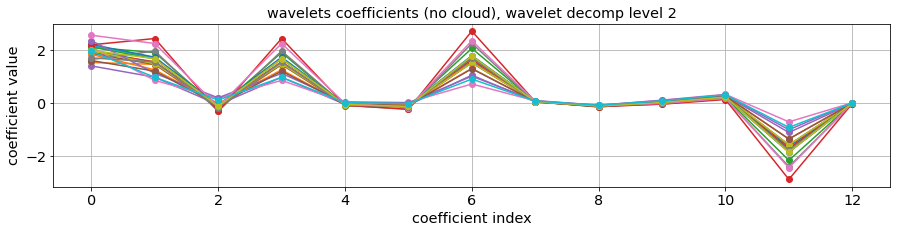

In [627]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
for idx in np.arange(20):
    ax.plot(coeff[idx,:],"o-")
ax.set_title("wavelets coefficients (no cloud), "+ ilevel_label)
ax.set_xlabel("coefficient index")
ax.set_ylabel("coefficient value")
ax.grid()

# Prepare data

In [628]:
vaodarr=vaod[:,np.newaxis]
pwvarr=pwv[:,np.newaxis]
o3arr=o3[:,np.newaxis]

### concatenate VAOD,PWV, Ozone

In [629]:
Y=np.concatenate((vaodarr,pwvarr,o3arr),axis=1)

In [630]:
X=coeff

## Splitting

In [631]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

In [632]:
X_val,X_test,Y_val,Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

## Scaling

In [633]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

In [634]:
FLAG_SCALING=True

In [635]:
scaler_X.fit(X_train) 
scaler_Y.fit(Y_train) 

StandardScaler()

In [636]:
scaler_X.mean_.shape

(13,)

In [637]:
scaler_X.scale_.shape

(13,)

In [638]:
scaler_Y.mean_.shape

(3,)

In [639]:
scaler_Y.scale_.shape

(3,)

In [640]:
X_train_scaled = scaler_X.transform(X_train)
Y_train_scaled = scaler_Y.transform(Y_train)    
X_val_scaled = scaler_X.transform(X_val)
Y_val_scaled = scaler_Y.transform(Y_val)
X_test_scaled = scaler_X.transform(X_test)
Y_test_scaled = scaler_Y.transform(Y_test)

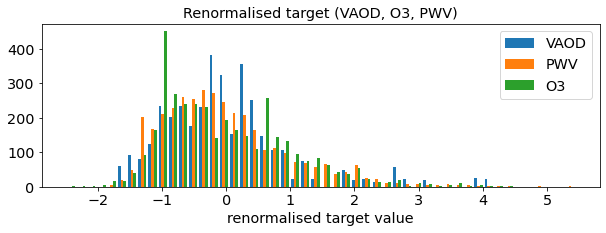

In [641]:
fig=plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.hist(np.concatenate((Y_train_scaled,Y_val_scaled,Y_test_scaled),axis=0),bins=50,label=["VAOD","PWV","O3"])
ax.set_title("Renormalised target (VAOD, O3, PWV)")
ax.set_xlabel("renormalised target value")
ax.legend()

## Linear regression model

In [642]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score

In [643]:
reg = linear_model.LinearRegression()

In [644]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [645]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets

if FLAG_SCALING:
    regr.fit(X_train_scaled, Y_train_scaled)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test_scaled)
else:
    regr.fit(X_train, Y_train)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test)



# The coefficients
print('Coefficients: \n', regr.coef_)
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))


Coefficients: 
 [[ 8.89395086e-01 -2.09859926e-03  2.49259642e-01 -2.09859926e-03
  -8.67040882e-02  2.49789802e-02 -2.67518342e-02 -9.30259732e-02
   1.40797599e-01 -1.06315207e-02 -1.38711561e-02 -2.28348735e-02
  -9.28959830e-04]
 [-2.12217886e-01  1.76549208e-01  1.72594330e+00  1.76549208e-01
   7.50423628e-02  3.34029911e+00 -5.42254283e+00 -2.66602317e-01
  -6.30693084e-01 -3.13549311e+00 -3.26004463e+00 -3.89171850e+00
   1.12527802e-01]
 [-9.52377150e-02  1.69570136e-02  1.01117882e+00  1.69570136e-02
  -4.79965174e-01 -1.60252782e+00  2.00752014e+00  1.57767636e+00
  -2.23801646e+00  9.18188493e-01  1.16636855e+00  1.54180636e+00
   2.19560532e-02]]
Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


# Linear Regression with Ridge

In [646]:
from sklearn import linear_model
regr_ridge = linear_model.Ridge(alpha=1e-5)

In [647]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_ridge.fit(X_train_scaled, Y_train_scaled)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test_scaled)
else:
    regr_ridge.fit(X_train, Y_train)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test)

print(regr_ridge)

# The coefficients
print('Coefficients: \n', regr_ridge.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))

Ridge(alpha=1e-05)
Coefficients: 
 [[ 0.85988263  0.00774474  0.30836427  0.00774474 -0.03843822  0.03206942
  -0.07135049 -0.12374444  0.09442466 -0.04697114 -0.02820704 -0.04415392
   0.01570108]
 [ 1.60004645 -0.12175983 -1.63596119 -0.12175989  0.65477437  2.07691973
  -1.80735356 -0.48992734  0.4444176  -0.38140373 -1.64175881 -1.51395535
  -1.15286238]
 [-0.30891317 -0.01393789  1.18333844 -0.01393786 -0.59187908 -1.18568415
   1.26160982  1.64174829 -2.23414868  0.60017439  0.69686879  0.91868836
   0.23820103]]
Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


## Tune hyper parameter with Ridge

In [648]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-10, -1, n_alphas)
all_MSE = []

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=True)
    
    if FLAG_SCALING:
    
        ridge.fit(X_train_scaled,Y_train_scaled)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        ridge.fit(X_train,Y_train)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE result
    all_MSE.append(MSE)
    
allcoefs=np.array(coefs)
alphas=np.array(alphas)
all_MSE=np.array(all_MSE)

<Figure size 1080x1080 with 0 Axes>

In [649]:
idx_min=np.where(all_MSE==all_MSE.min())[0][0]

In [650]:
alpha_ridge_min=alphas[idx_min]
alpha_ridge_min

1e-10

In [651]:
ilevel_label

'wavelet decomp level 2'

In [652]:
RIDGE_MSE_THRES=[
    5e-9,
    5e-9,      #level 1
    0.1e-6,      #level 2 
    5e-9,      #level 3 
    5e-9,      #level 4
    5e-9,      #level 5
    5e-9,      #level 6
    5e-9,      #level 7
    5e-9,      #level 8
    5e-9,      #level 9
]

0.00044487828311275856

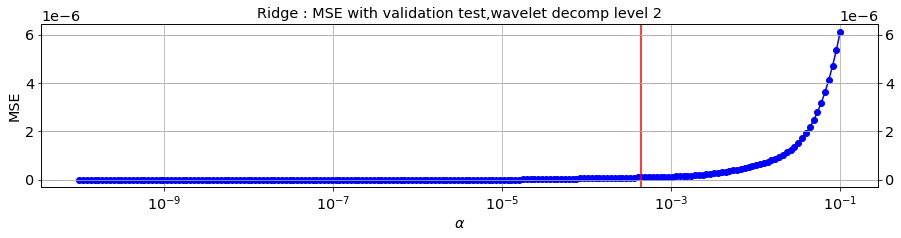

In [653]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")

idx_min=np.where(all_MSE<RIDGE_MSE_THRES[ilevel])[0][-1]

alpha_ridge=alphas[idx_min]
ax.axvline(x=alpha_ridge,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.grid()
ax.set_title("Ridge : MSE with validation test," + ilevel_label)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()
alpha_ridge

### Display results

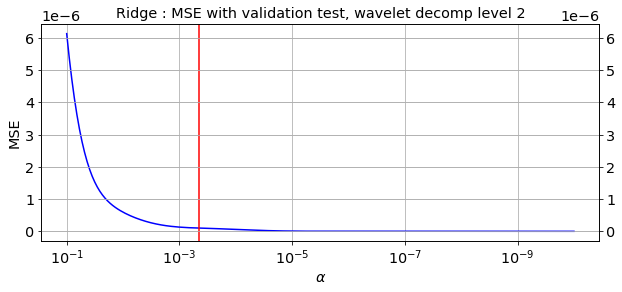

In [654]:
fig=plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
ax.axvline(x=alpha_ridge,color='red')
#ax.set_yscale('log')
ax.grid()
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("Ridge : MSE with validation test, "+ilevel_label)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()

In [655]:
alpha_ridge_sel=alpha_ridge
alpha_ridge_label="($\\alpha$ = {:1.3e})".format(alpha_ridge_sel)

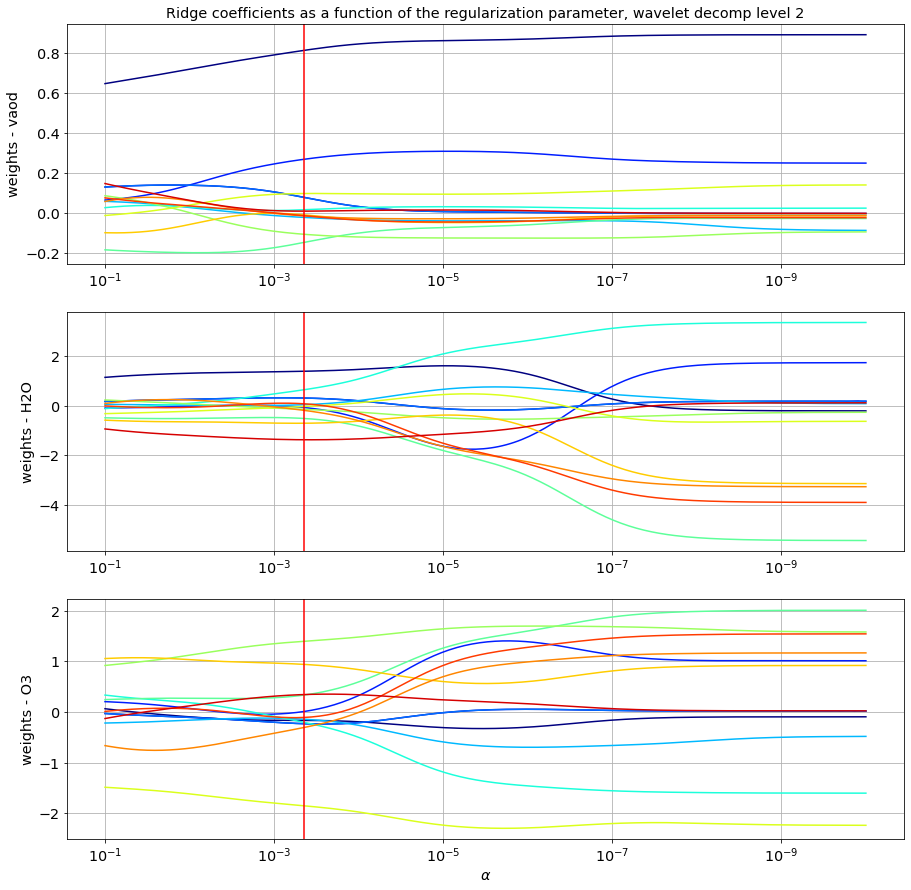

In [656]:
fig=plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(311)
for idx in np.arange(allcoefs.shape[2]):
    ax1.plot(alphas, allcoefs[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.grid(True)
ax1.axvline(x=alpha_ridge_sel,color='red')
ax1.set_title('Ridge coefficients as a function of the regularization parameter, '+ ilevel_label)

ax2 = fig.add_subplot(312,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax2.plot(alphas, allcoefs[:,1,idx],color=all_colors[idx])
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.axvline(x=alpha_ridge_sel,color='red')
ax2.grid(True)

ax3= fig.add_subplot(313,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax3.plot(alphas, allcoefs[:,2,idx],color=all_colors[idx])
ax3.set_ylabel('weights - O3')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.axvline(x=alpha_ridge_sel,color='red')
ax3.grid(True)

plt.xlabel('$\\alpha$')
plt.axis('tight')
plt.show()

# Linear Regression with Lasso

In [657]:
from sklearn import linear_model

In [658]:
regr_lasso = linear_model.Lasso(alpha=1e-5)

In [659]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_lasso.fit(X_train_scaled, Y_train_scaled)
    Y_pred_lasso = regr_lasso.predict(X_test_scaled)
    
else:
    regr_lasso.fit(X_train, Y_train)
    Y_pred_lasso = regr_lasso.predict(X_test)
    
    
# The coefficients
print('Coefficients: \n', regr_lasso.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_lasso))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_lasso))

Coefficients: 
 [[ 0.90187669 -0.1358564   0.08312239  0.03200702  0.00603285  0.02072957
   0.01774645 -0.04488771  0.08764802 -0.01906128  0.02353377 -0.02522062
   0.04976831]
 [ 0.91899219  0.46509492 -0.37836481 -0.15306394  0.23441908 -0.52631763
  -0.40119031  0.40434047 -0.45524772 -0.30515442 -0.00143622  0.25273126
  -0.65410274]
 [ 0.42444551 -0.36061631  0.38440314  0.16578065 -0.20870928  0.4157706
   0.49530626  0.54944959 -1.34293136  1.16122069 -0.62422876  0.00854593
  -0.45942633]]
Mean squared error: 0.00004
Coefficient of determination: 0.99996
Explained variance: 0.99996


In [660]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 20
alphas = np.logspace(-10, -1, n_alphas)

all_MSE = []
coefs = []
coefs_noconst = []

for a in alphas:
    # fit with intercept
    lasso = linear_model.Lasso(alpha=a, fit_intercept=True,max_iter=1000)
    # fit without intercept
    lasso2 = linear_model.Lasso(alpha=a, fit_intercept=False,max_iter=1000)
        
    if FLAG_SCALING:
        lasso.fit(X_train_scaled,Y_train_scaled);
        lasso2.fit(X_train_scaled,Y_train_scaled);
    else:
        lasso.fit(X_train,Y_train);
        lasso2.fit(X_train,Y_train);
            
    # book coefficients        
    coefs.append(lasso.coef_) 
    coefs_noconst.append(lasso2.coef_)
    
    # calculate metric
    # Make predictions using the testing set
    
    if FLAG_SCALING:
        Y_pred = lasso.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        Y_pred = lasso.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE    
    all_MSE.append(MSE)

alphas=np.array(alphas)
allcoefs=np.array(coefs)
allcoefs2=np.array(coefs_noconst)
all_MSE=np.array(all_MSE)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23259908351794978, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23259908351804504, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.41174742232271766, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might 

<Figure size 1080x1080 with 0 Axes>

In [661]:
idx_min=np.where(all_MSE==all_MSE.min())[0][0]

In [662]:
alpha_lasso_min=alphas[idx_min]
alpha_lasso_min

4.8329302385717524e-05

In [663]:
LASSO_MSE_THRES=[
    1e-7,
    0.016,      #level 1
    0.0005,      #level 2 
    1e-7,      #level 3 
    1e-7,      #level 4
    1e-7,      #level 5
    1e-7,      #level 6
    1e-7,      #level 7
    1e-7,      #level 8
    1e-7,      #level 9
]

0.0012742749857031321

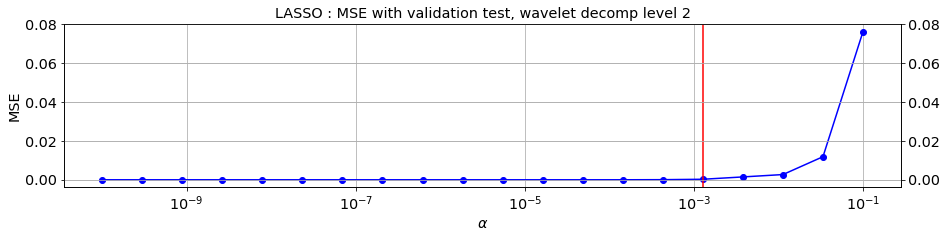

In [664]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")

#idx_min=np.where(all_MSE==all_MSE.min())[0][0]

idx_min=np.where(all_MSE<LASSO_MSE_THRES[ilevel])[0][-1]

alpha_lasso=alphas[idx_min]
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test, "+ilevel_label)
ax.grid()
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()
alpha_lasso

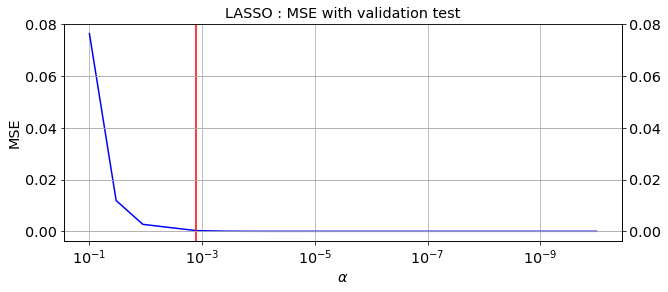

In [665]:
fig=plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test")
ax.grid()
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()

In [666]:
# Final selection
alpha_lasso_sel=alpha_lasso
alpha_lasso_label="( $\\alpha$ = {:1.3e})".format(alpha_lasso_sel)

In [667]:
alpha_lasso_label

'( $\\alpha$ = 1.274e-03)'

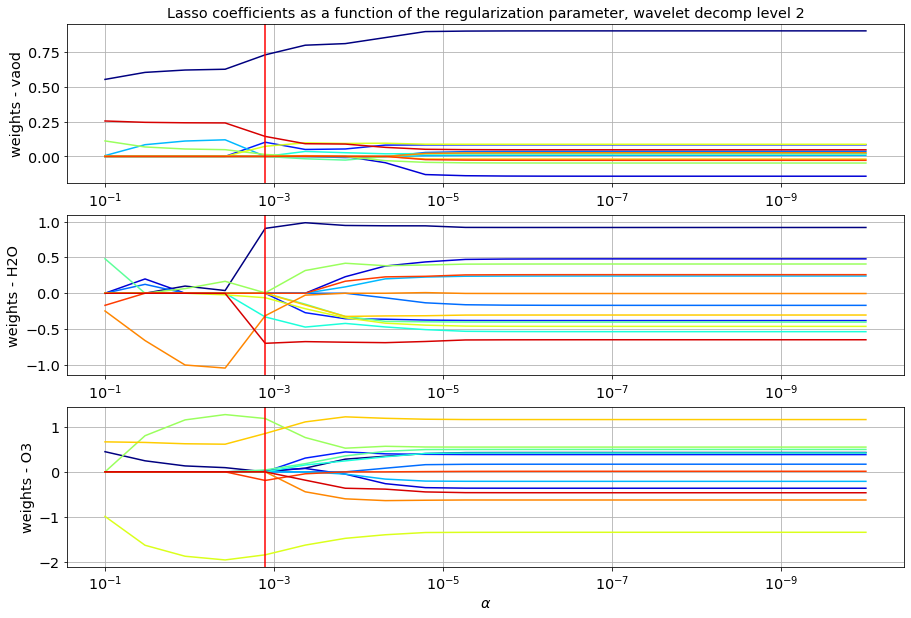

In [668]:
fig=plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(311)
for idx in np.arange(allcoefs2.shape[2]):
    ax1.plot(alphas, allcoefs2[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.grid(True)
ax1.axvline(x=alpha_lasso_sel,color='red')
ax1.set_title('Lasso coefficients as a function of the regularization parameter, '+ilevel_label)

ax2 = fig.add_subplot(312,sharex=ax1)
for idx in np.arange(allcoefs2.shape[2]):
    ax2.plot(alphas, allcoefs2[:,1,idx],color=all_colors[idx])
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.axvline(x=alpha_lasso_sel,color='red')
ax2.grid(True)

ax3= fig.add_subplot(313,sharex=ax2)
for idx in np.arange(allcoefs2.shape[2]):
    ax3.plot(alphas, allcoefs2[:,2,idx],color=all_colors[idx])
ax3.set_ylabel('weights - O3')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.axvline(x=alpha_lasso_sel,color='red')
ax3.grid(True)

plt.xlabel('$\\alpha$')
plt.axis('tight')
plt.show()

# Verification with test  set

## Check learning curves

In [669]:
nb_tot_test=len(Y_test)

In [670]:
nsamples=np.arange(10,nb_tot_test,10)

### Leraning curves for linear regression

In [671]:
all_MSE_train=np.zeros(len(nsamples))
all_MSE_test=np.zeros(len(nsamples))

In [672]:
count=0
for n in nsamples:
    
    regr = linear_model.LinearRegression(fit_intercept=True)
  
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        X_test_cut=np.copy(X_test_scaled[:n,:])
        Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        X_test_cut=X_test[:n,:]
        Y_test_cut=Y_test[:n,:]  
        
    regr.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = regr.predict(X_train_cut)
    Y_pred_test  = regr.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

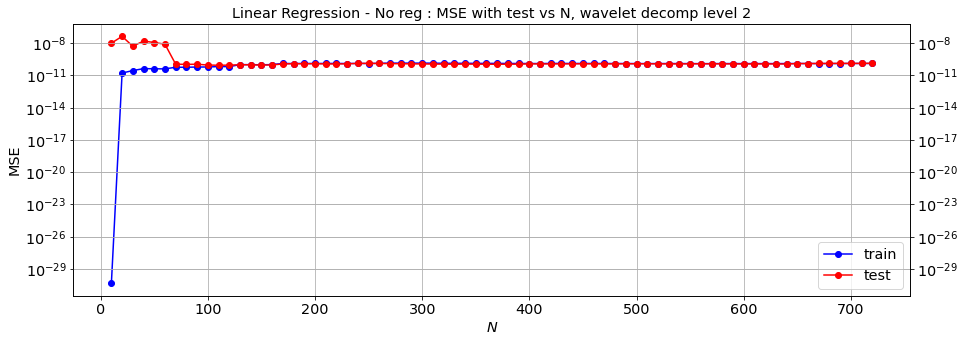

In [673]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples, all_MSE_train,'b-o',label="train")
ax.plot(nsamples, all_MSE_test,'r-o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("Linear Regression - No reg : MSE with test vs N, "+ilevel_label)
ax.grid()
#ax.set_ylim(1e-6,1e-2)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

### Learning curves for Ridge

In [674]:
all_MSE_train=np.zeros(len(nsamples))
all_MSE_test=np.zeros(len(nsamples))

In [675]:
alpha_ridge

0.00044487828311275856

In [676]:
alpha_ridge=1e-4

In [677]:
count=0
for n in nsamples:
    

    ridge = linear_model.Ridge(alpha=alpha_ridge_min, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        X_test_cut=np.copy(X_test_scaled[:n,:])
        Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        X_test_cut=X_test[:n,:]
        Y_test_cut=Y_test[:n,:]  
        
    ridge.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = ridge.predict(X_train_cut)
    Y_pred_test  = ridge.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

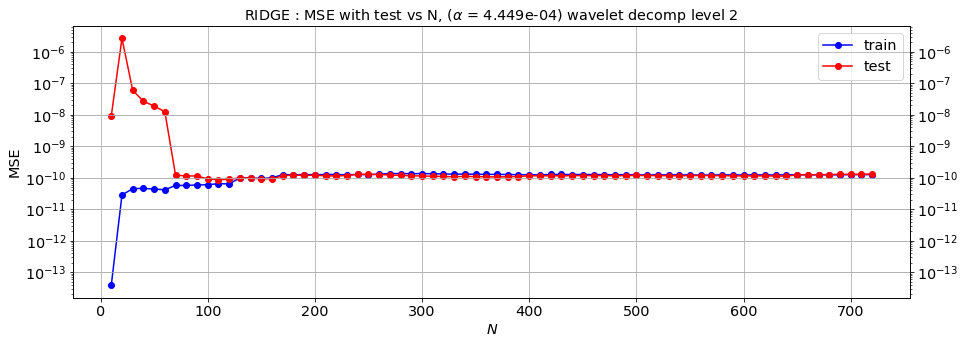

In [678]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples, all_MSE_train,'b-o',label="train")
ax.plot(nsamples, all_MSE_test,'r-o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("RIDGE : MSE with test vs N, "+alpha_ridge_label+" "+ilevel_label)
ax.grid()
#ax.set_ylim(1e-6,1e-2)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

### Learning curves for Lasso

In [679]:
all_MSE_train=np.zeros(len(nsamples))
all_MSE_test=np.zeros(len(nsamples))

In [680]:
alpha_lasso

0.0012742749857031321

In [681]:
alpha_lasso_min

4.8329302385717524e-05

In [682]:
alpha_lasso_0=1e-3

In [683]:
count=0
for n in nsamples:
    

    lasso = linear_model.Lasso(alpha=alpha_lasso_0, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        X_test_cut=np.copy(X_test_scaled[:n,:])
        Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        X_test_cut=X_test[:n,:]
        Y_test_cut=Y_test[:n,:]  
        
    lasso.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = lasso.predict(X_train_cut)
    Y_pred_test  = lasso.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010807213660557712, tolerance: 0.0007725971819792289
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003935070042461977, tolerance: 0.0009441401114404035
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012799699243664276, tolerance: 0.0019939459391382173
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. Y

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1538429004858103, tolerance: 0.038274926728331535
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1741425481559189, tolerance: 0.03888003565309831
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18294034907430234, tolerance: 0.03943894286465572
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

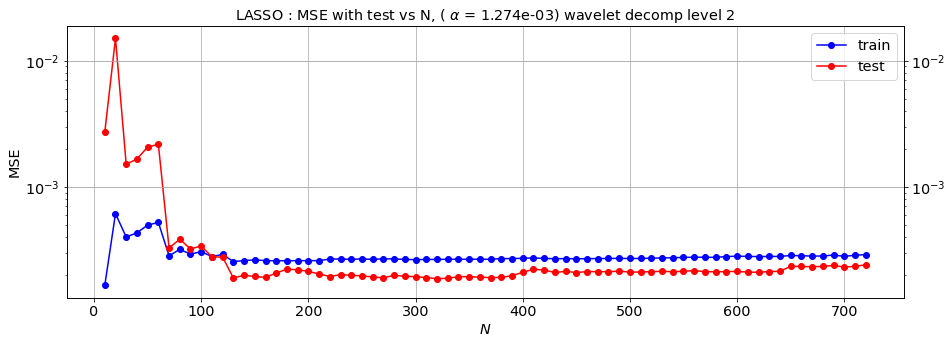

In [684]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples, all_MSE_train,'b-o',label="train")
ax.plot(nsamples, all_MSE_test,'r-o',label="test")
ax.legend()
ax.grid()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with test vs N, "+ alpha_lasso_label+" "+ilevel_label)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

# Final

# No regularisation

In [685]:
regr = linear_model.LinearRegression(fit_intercept=True)
    
if FLAG_SCALING:           
    regr.fit(X_train_scaled,Y_train_scaled)
else:
    regr.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = regr.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = regr.predict(X_test)
    DY=Y_pred_test-Y_test
    

In [686]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


Text(0.5, 1.1, 'Linear Regression - No reg (no cloud), wavelet decomp level 2')

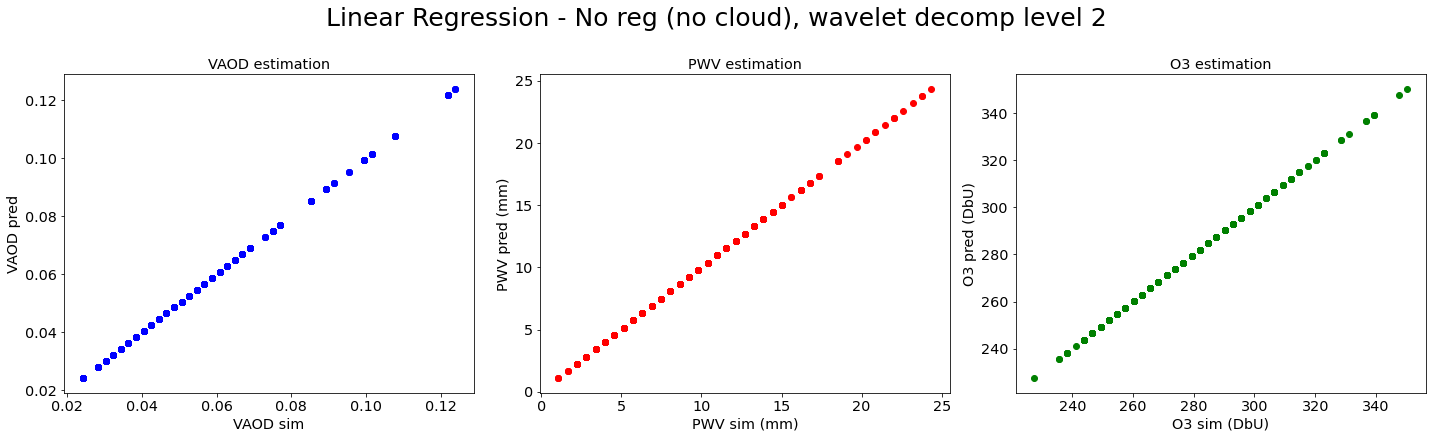

In [687]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("VAOD pred")
ax.set_title("VAOD estimation")

ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1],'ro')
ax.set_xlabel("PWV sim (mm)")
ax.set_ylabel("PWV pred (mm)")
ax.set_title("PWV estimation")


ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2],'go')
ax.set_xlabel("O3 sim (DbU)")
ax.set_ylabel("O3 pred (DbU)")
ax.set_title("O3 estimation")

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (no cloud), "+ ilevel_label,Y=1.1,fontsize=25)

Text(0.5, 1.1, 'Linear Regression + No Reg (no cloud), wavelet decomp level 2')

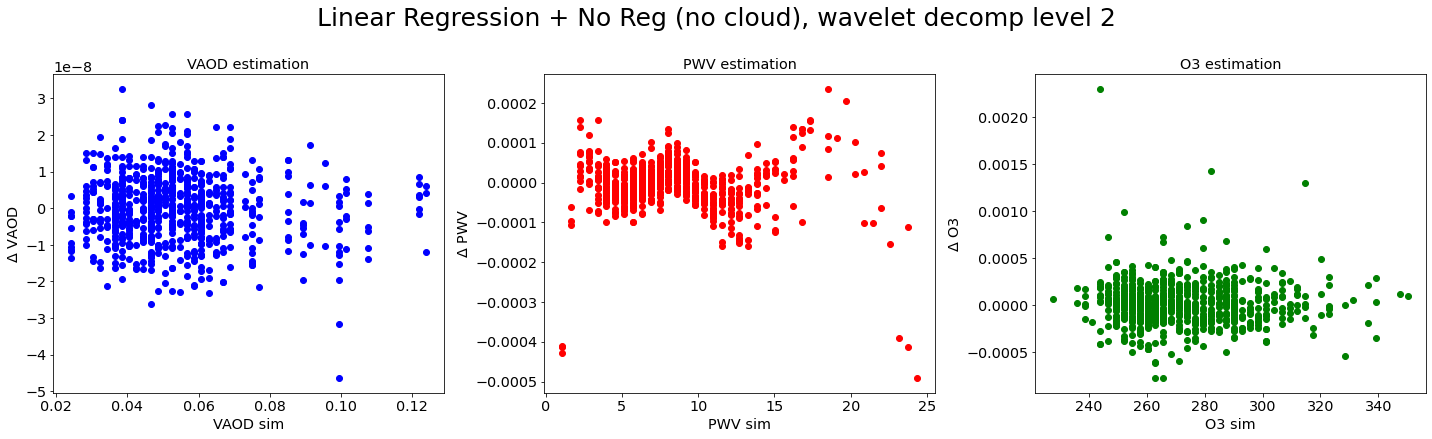

In [688]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0]-Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1]-Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV")
ax.set_title("PWV estimation")
#ax.set_ylim(-0.002,0.002)


ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2]-Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3")
ax.set_title("O3 estimation")

plt.tight_layout()
plt.suptitle("Linear Regression + No Reg (no cloud), "+ ilevel_label,Y=1.1,fontsize=25)

Text(0.5, 1.1, 'Linear Regression + No Reg reg, (no cloud), wavelet decomp level 2')

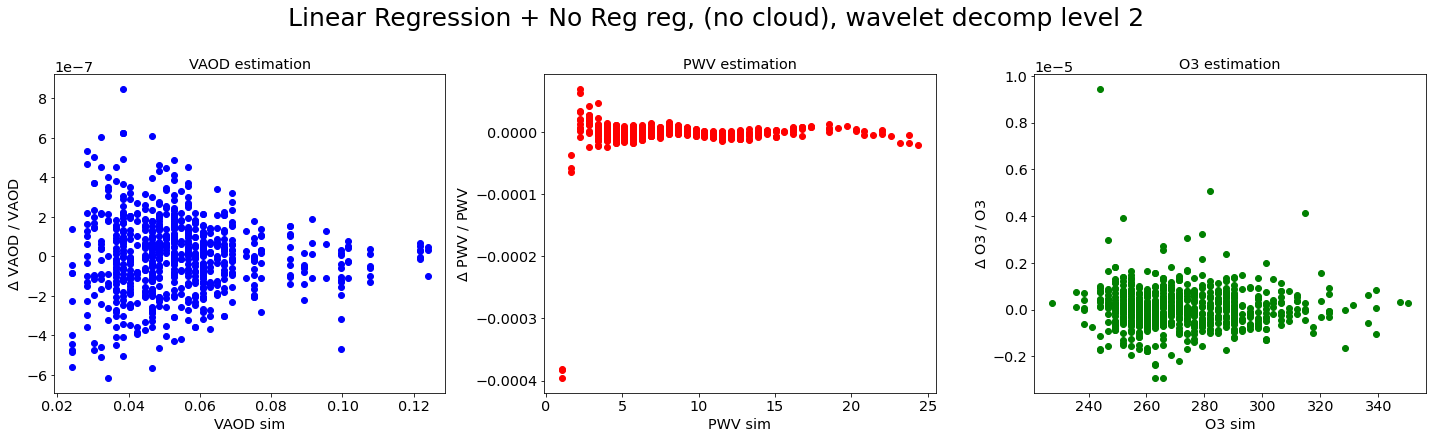

In [689]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],(Y_pred_test_inv[:,0]-Y_test[:,0])/Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD / VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],(Y_pred_test_inv[:,1]-Y_test[:,1])/Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV / PWV")
ax.set_title("PWV estimation")

ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],(Y_pred_test_inv[:,2]-Y_test[:,2])/Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3 / O3")
ax.set_title("O3 estimation")

plt.tight_layout()
plt.suptitle("Linear Regression + No Reg reg, (no cloud), "+ ilevel_label,Y=1.1,fontsize=25)

## Ridge

In [690]:
ridge = linear_model.Ridge(alpha=alpha_ridge_min, fit_intercept=True)
    
if FLAG_SCALING:           
    ridge.fit(X_train_scaled,Y_train_scaled)
else:
    ridge.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = ridge.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = ridge.predict(X_test)
    DY=Y_pred_test-Y_test
    
    


In [691]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


In [692]:
ridge.coef_

array([[ 8.89376213e-01, -2.13781455e-03,  2.49359095e-01,
        -2.04548701e-03, -8.60382130e-02,  2.49305618e-02,
        -2.67120331e-02, -9.34354790e-02,  1.40449995e-01,
        -1.06239168e-02, -1.38484735e-02, -2.27960558e-02,
        -9.20935441e-04],
       [-2.11638036e-01,  1.73782106e-01,  1.72505284e+00,
         1.79077124e-01,  7.85330497e-02,  3.33975604e+00,
        -5.42119919e+00, -2.68693218e-01, -6.31938786e-01,
        -3.13443200e+00, -3.25950376e+00, -3.89085689e+00,
         1.12140396e-01],
       [-9.52958389e-02,  1.65948720e-02,  1.01110766e+00,
         1.73280332e-02, -4.82059295e-01, -1.60232242e+00,
         2.00719483e+00,  1.57895472e+00, -2.23702172e+00,
         9.17988060e-01,  1.16622098e+00,  1.54156647e+00,
         2.20058927e-02]])

Text(0.5, 1.1, 'Linear Regression + Ridge reg, (no cloud), wavelet decomp level 2')

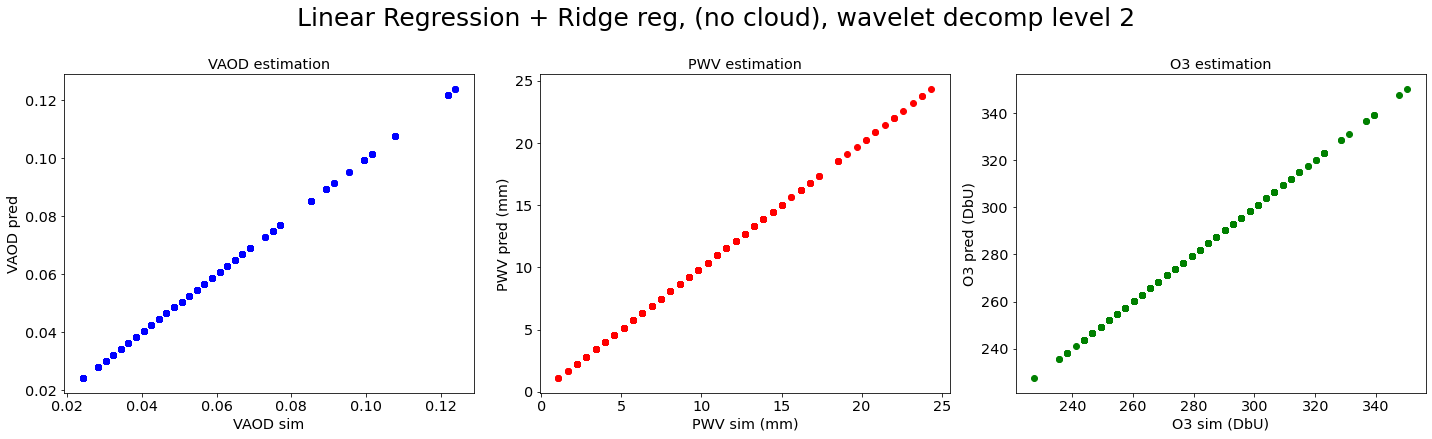

In [693]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("VAOD pred")
ax.set_title("VAOD estimation")

ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1],'ro')
ax.set_xlabel("PWV sim (mm)")
ax.set_ylabel("PWV pred (mm)")
ax.set_title("PWV estimation")


ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2],'go')
ax.set_xlabel("O3 sim (DbU)")
ax.set_ylabel("O3 pred (DbU)")
ax.set_title("O3 estimation")

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (no cloud), "+ ilevel_label,Y=1.1,fontsize=25)

Text(0.5, 1.1, 'Linear Regression + Ridge reg, (no cloud), wavelet decomp level 2')

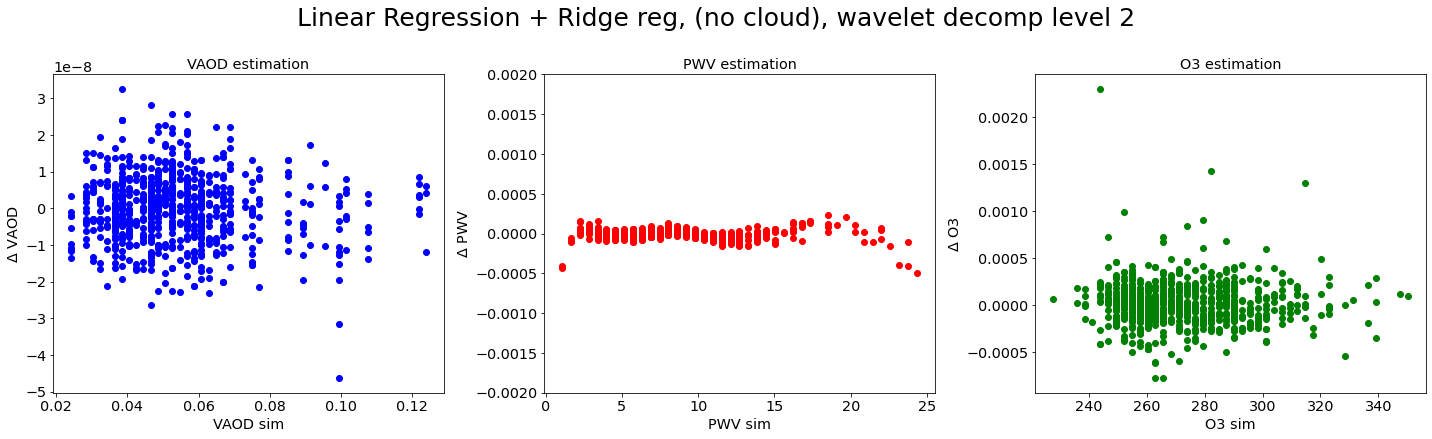

In [694]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0]-Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1]-Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV")
ax.set_title("PWV estimation")
ax.set_ylim(-0.002,0.002)


ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2]-Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3")
ax.set_title("O3 estimation")

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (no cloud), "+  ilevel_label,Y=1.1,fontsize=25)

Text(0.5, 1.1, 'Linear Regression + Ridge reg, (no cloud), wavelet decomp level 2')

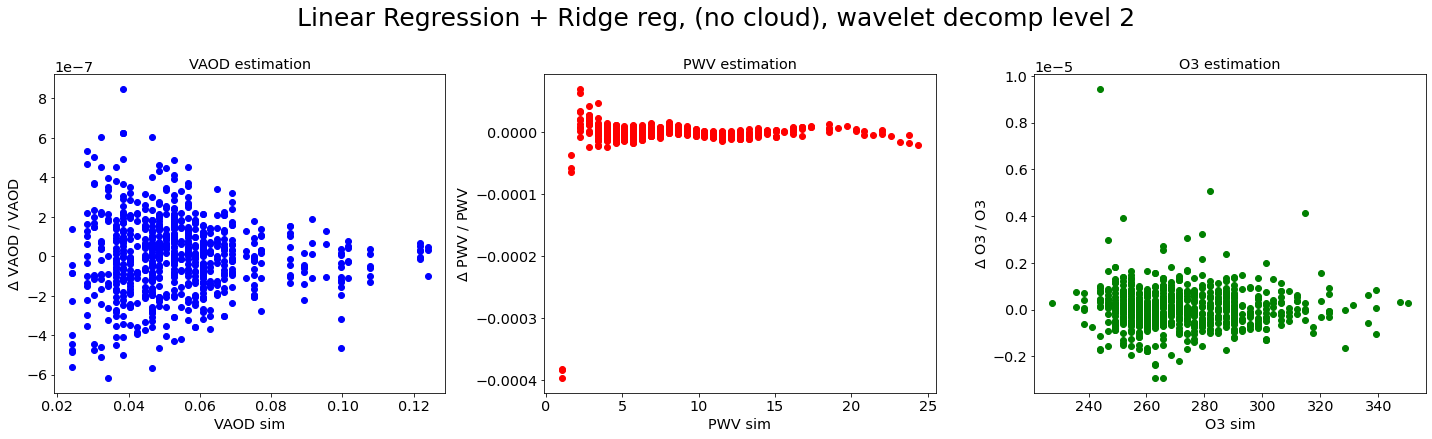

In [695]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],(Y_pred_test_inv[:,0]-Y_test[:,0])/Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD / VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],(Y_pred_test_inv[:,1]-Y_test[:,1])/Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV / PWV")
ax.set_title("PWV estimation")

ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],(Y_pred_test_inv[:,2]-Y_test[:,2])/Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3 / O3")
ax.set_title("O3 estimation")

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (no cloud), "+ ilevel_label,Y=1.1,fontsize=25)

## Lasso

In [696]:
#lasso = linear_model.Lasso(alpha=alpha_lasso_min, fit_intercept=True)
lasso = linear_model.Lasso(alpha=alpha_lasso_0, fit_intercept=True)
    
if FLAG_SCALING:           
    lasso.fit(X_train_scaled,Y_train_scaled)
else:
    lasso.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = lasso.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = lasso.predict(X_test)
    DY=Y_pred_test-Y_test
    
    

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2952280247486916, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9080119818709144, tolerance: 0.2190000000000001
  positive)


In [697]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.00034
Coefficient of determination: 0.99967
Explained variance: 0.99967


Text(0.5, 1.1, 'Linear Regression + Lasso reg, (no cloud), wavelet decomp level 2')

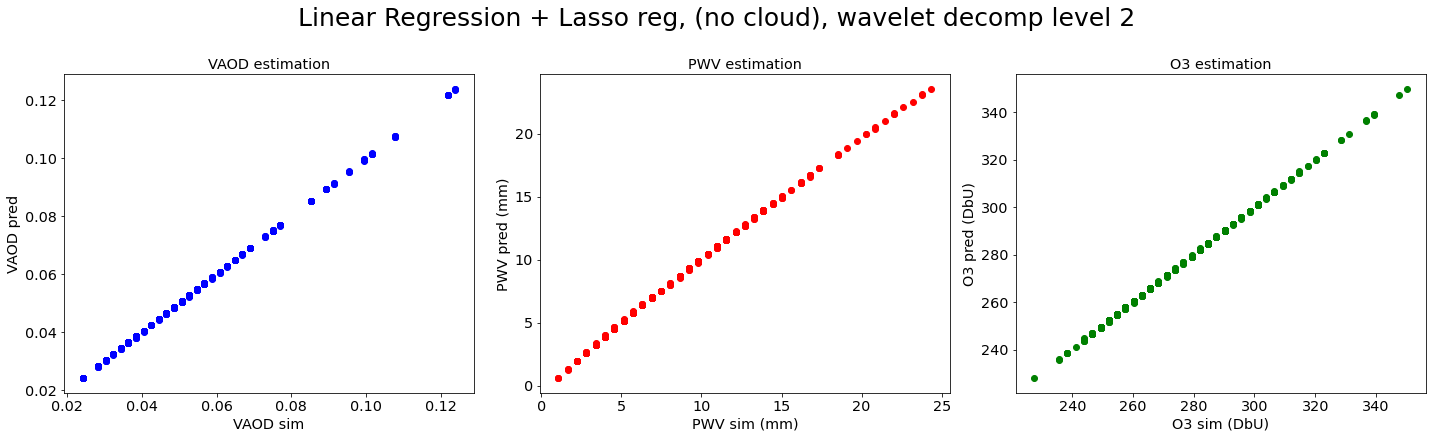

In [698]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("VAOD pred")
ax.set_title("VAOD estimation")

ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1],'ro')
ax.set_xlabel("PWV sim (mm)")
ax.set_ylabel("PWV pred (mm)")
ax.set_title("PWV estimation")

ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2],'go')
ax.set_xlabel("O3 sim (DbU)")
ax.set_ylabel("O3 pred (DbU)")
ax.set_title("O3 estimation")

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (no cloud), "+  ilevel_label,Y=1.1,fontsize=25)

Text(0.5, 1.1, 'Linear Regression + Lasso reg, (no cloud), wavelet decomp level 2')

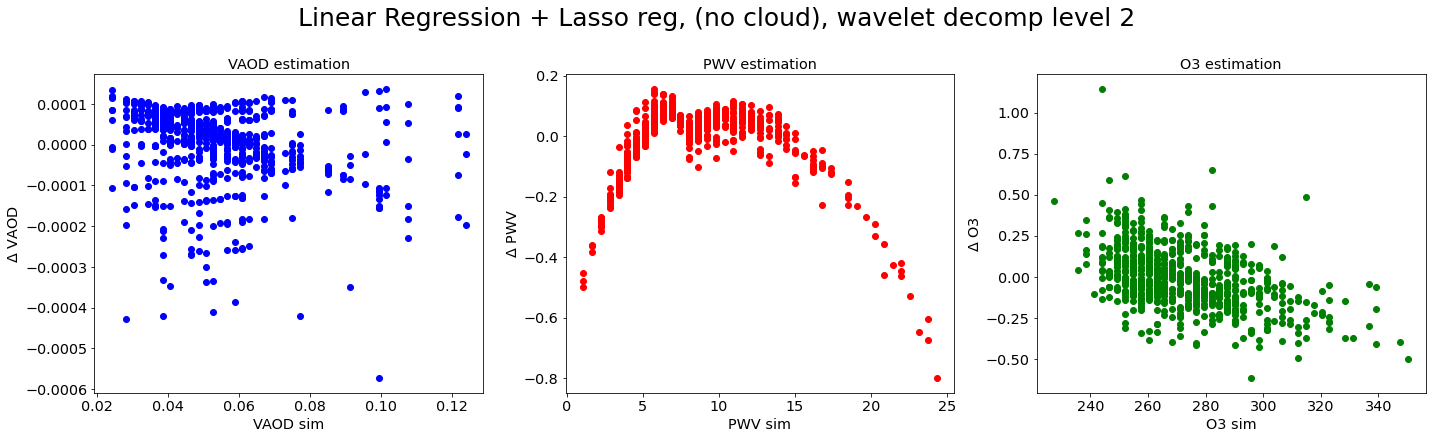

In [699]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0]-Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1]-Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV")
ax.set_title("PWV estimation")
#ax.set_ylim(-0.002,0.002)


ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2]-Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3")
ax.set_title("O3 estimation")

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (no cloud), "+  ilevel_label,Y=1.1,fontsize=25)

Text(0.5, 1.1, 'Linear Regression + Lasso reg, (no cloud), wavelet decomp level 2')

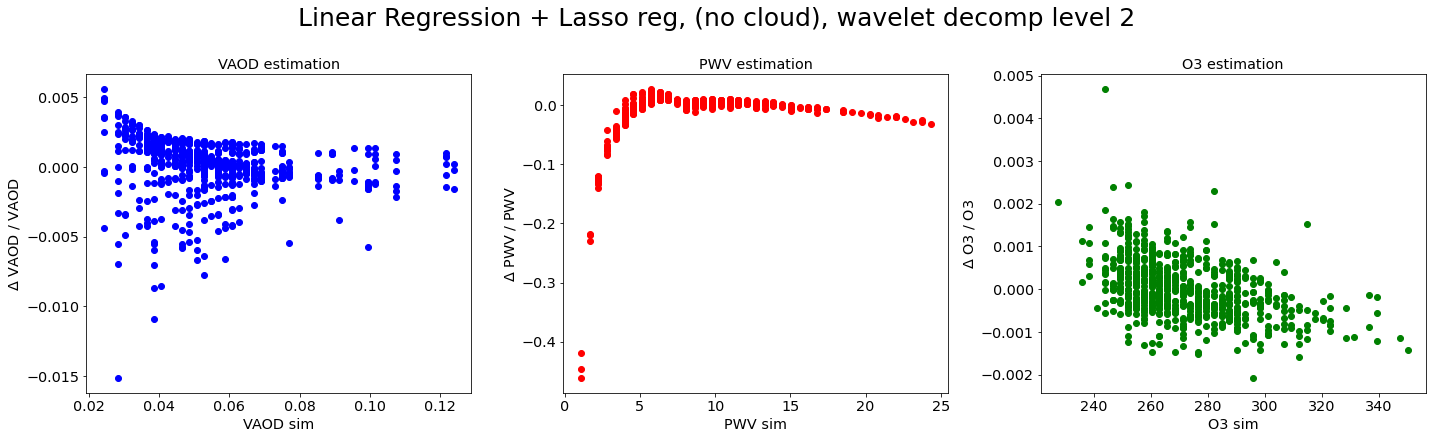

In [700]:
fig=plt.figure(figsize=(20,5.5))
ax = fig.add_subplot(131)
ax.plot(Y_test[:,0],(Y_pred_test_inv[:,0]-Y_test[:,0])/Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD / VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(132)
ax.plot(Y_test[:,1],(Y_pred_test_inv[:,1]-Y_test[:,1])/Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV / PWV")
ax.set_title("PWV estimation")

ax = fig.add_subplot(133)
ax.plot(Y_test[:,2],(Y_pred_test_inv[:,2]-Y_test[:,2])/Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3 / O3")
ax.set_title("O3 estimation")

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (no cloud), "+  ilevel_label,Y=1.1,fontsize=25)